In [873]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D

# 1. The QM7 Dataset

In [874]:
data = sio.loadmat("./qm7.mat")

R = data['R']
Z = data['Z']
T = data['T']
T_Copy = data['T'] # Will be used to verify the predicted results later on
print(R.shape)
print(Z.shape)
print(T.shape)
 

(7165, 23, 3)
(7165, 23)
(1, 7165)


## 1.1 Visualizing Molecules

In [875]:
# Finding out non-zero atoms in the first molecule R[0] and gather 2D and 3D coordinates for those atoms
two_d_point_arr_non_empty_atoms = []
three_d_point_arr_non_empty_atoms = []

for i in range(len(R[0])) :
    temp_arr_1 = []
    temp_arr_2 = []
    if(R[0][i][0] == 0.0 and R[0][i][1] == 0.0 and R[0][i][2] == 0.0 ):
        pass
    else:
        temp_arr_1.append(R[0][i][0])
        temp_arr_1.append(R[0][i][1])
        two_d_point_arr_non_empty_atoms.append(temp_arr_1)
        temp_arr_2.append(R[0][i][0])
        temp_arr_2.append(R[0][i][1])
        temp_arr_2.append(R[0][i][2])
        three_d_point_arr_non_empty_atoms.append(temp_arr_2)

In [876]:
# Setting a threshold value. We got this value by chhecking the distances array for the first molecule
# This value was chosen as almost a mid point value for the distance matrix
threshold = 2.5

np_two_d_point_arr_non_empty_atoms shape :  (5, 2)


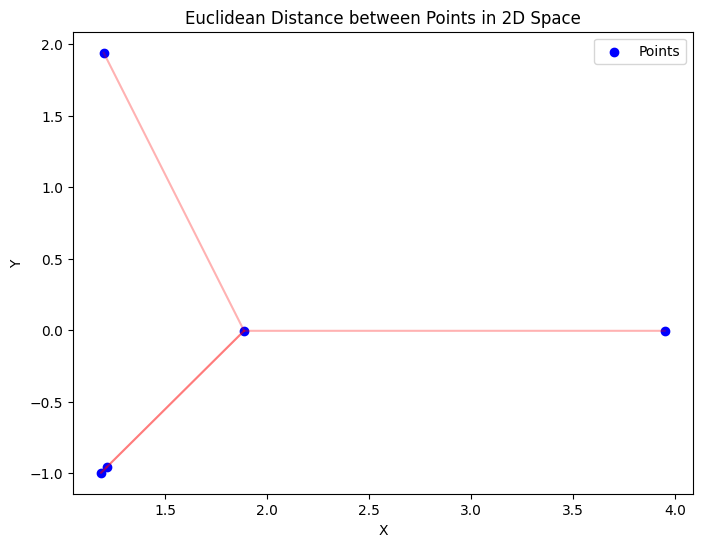

In [877]:
# 2D Euclidean distance calculation and 2D plotting 

np_two_d_point_arr_non_empty_atoms = np.array(two_d_point_arr_non_empty_atoms)

print("np_two_d_point_arr_non_empty_atoms shape : ", np_two_d_point_arr_non_empty_atoms.shape)

# Calculate 2D Euclidean distance between points
distances = np.zeros((np_two_d_point_arr_non_empty_atoms.shape[0], np_two_d_point_arr_non_empty_atoms.shape[0]))
for i in range(np_two_d_point_arr_non_empty_atoms.shape[0]):
    for j in range(np_two_d_point_arr_non_empty_atoms.shape[0]):
        distances[i, j] = np.linalg.norm(np_two_d_point_arr_non_empty_atoms[i] - np_two_d_point_arr_non_empty_atoms[j])

# Plotting
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Scatter plot of points
ax.scatter(np_two_d_point_arr_non_empty_atoms[:, 0], np_two_d_point_arr_non_empty_atoms[:, 1], color='blue', label='Points')

# Plotting lines for Euclidean distances
for i in range(np_two_d_point_arr_non_empty_atoms.shape[0]):
    for j in range(i+1, np_two_d_point_arr_non_empty_atoms.shape[0]):
        if(distances[i][j] <= threshold): # plotting lines based on threshold value of 3.0
            x = [np_two_d_point_arr_non_empty_atoms[i, 0], np_two_d_point_arr_non_empty_atoms[j, 0]]
            y = [np_two_d_point_arr_non_empty_atoms[i, 1], np_two_d_point_arr_non_empty_atoms[j, 1]]
            ax.plot(x, y, color='red', alpha=0.3)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Euclidean Distance between Points in 2D Space')
plt.legend()
plt.show()

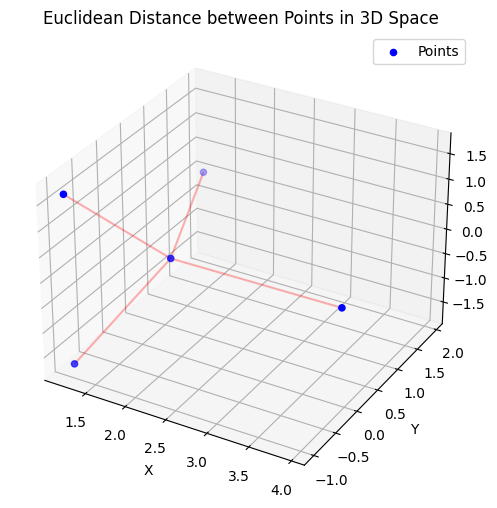

In [878]:
# 3D Euclidean distance calculation and 3D plotting 

np_three_d_point_arr_non_empty_atoms = np.array(three_d_point_arr_non_empty_atoms)

# Calculate 3D Euclidean distance between points
distances = np.zeros((np_three_d_point_arr_non_empty_atoms.shape[0], np_three_d_point_arr_non_empty_atoms.shape[0]))
for i in range(np_three_d_point_arr_non_empty_atoms.shape[0]):
    for j in range(np_three_d_point_arr_non_empty_atoms.shape[0]):
        distances[i, j] = np.linalg.norm(np_three_d_point_arr_non_empty_atoms[i] - np_three_d_point_arr_non_empty_atoms[j])

# Plotting
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of points
ax.scatter(np_three_d_point_arr_non_empty_atoms[:, 0], np_three_d_point_arr_non_empty_atoms[:, 1], np_three_d_point_arr_non_empty_atoms[:, 2], color='blue', label='Points')

# Plotting lines for Euclidean distances
for i in range(np_three_d_point_arr_non_empty_atoms.shape[0]):
    for j in range(i+1, np_three_d_point_arr_non_empty_atoms.shape[0]):
        if(distances[i][j] <= threshold):
            x = [np_three_d_point_arr_non_empty_atoms[i, 0], np_three_d_point_arr_non_empty_atoms[j, 0]]
            y = [np_three_d_point_arr_non_empty_atoms[i, 1], np_three_d_point_arr_non_empty_atoms[j, 1]]
            z = [np_three_d_point_arr_non_empty_atoms[i, 2], np_three_d_point_arr_non_empty_atoms[j, 2]]
            ax.plot(x, y, z, color='red', alpha=0.3)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Euclidean Distance between Points in 3D Space')
plt.legend()
plt.show()

# 2. Data Representation, ML Model and Explanations

## 2.1 Data Representation

In [879]:
# One hot encoding - for each atom

# 1 - hydrogen atom (H)
# 6 - carbon (C)
# 7 - nitrogen (N)
# 8 - oxygen (O)
# 16 - sulfur (S)

one_hot_encoding_atom_array = []
one_hot_encoded_molecule = []
x_vector_for_all_molecules = []

for molecule in Z:
    one_hot_encoded_molecule = []
    for atomic_number in molecule:
        if(atomic_number == 1.0):
            one_hot_encoding_atom_array = [1,0,0,0,0]
        elif(atomic_number == 6.0):
            one_hot_encoding_atom_array = [0,1,0,0,0]
        elif(atomic_number == 7.0):
            one_hot_encoding_atom_array = [0,0,1,0,0]
        elif(atomic_number == 8.0):
            one_hot_encoding_atom_array = [0,0,0,1,0]
        elif(atomic_number == 16.0):
            one_hot_encoding_atom_array = [0,0,0,0,1]
        else:
            one_hot_encoding_atom_array = [0,0,0,0,0]
        one_hot_encoded_molecule.append(one_hot_encoding_atom_array)
    x_vector = [ sum(x) for x in zip(*one_hot_encoded_molecule) ]
    x_vector_for_all_molecules.append(x_vector)

x_vector_for_all_molecules = np.array(x_vector_for_all_molecules)
print(x_vector_for_all_molecules.shape)

(7165, 5)


## 2.2 Ridge Regression Model

In [880]:
def get_weight(x_vector_for_all_molecules,T,lambd):

    # Finding auto covariance
    Cxx = (1/x_vector_for_all_molecules.shape[0])*np.dot(x_vector_for_all_molecules.T, x_vector_for_all_molecules)
    #print("shape of CXX is : ", Cxx.shape)

    # creating identity matrix
    I = np.identity(x_vector_for_all_molecules.shape[1])
    #print("Shape of I is: ", I.shape)

    # computing lamd * I
    lambd_I = lambd * I
    #print("Shape of lambd_I is: ", lambd_I.shape)

    # Finding cross covariance
    Cxt = (1/x_vector_for_all_molecules.shape[0])*np.dot(x_vector_for_all_molecules.T, T)
    #print("Shape of Cxt is : ", Cxt.shape)

    # Finding sum of Cxx and lamd * I
    temp_1 = Cxx + lambd_I
    #print("Shape of temp_1 is : ", temp_1.shape)

    # Find inverse of the previous step
    temp_2 = np.linalg.inv(temp_1)
    #print("Shape of temp_2 is : ", temp_2.shape)

    # Finding the weight W
    W = np.dot(temp_2,Cxt)
    #print("Shape of W is : ", W.shape)

    return W

In [881]:
# Centering the Data
x_vector_for_all_molecules = x_vector_for_all_molecules - np.mean(x_vector_for_all_molecules, axis =0, keepdims = True)

In [882]:
# Centering the Target
T = data['T']
print("Initial T.shape is : ", T.shape) # (1, 7165)
T = T - np.mean(T, axis = 1) # Finding the mean for the only 1 row that we have
print("T.shape after mean subtraction is : ", T.shape)
T = T.reshape(-1,1) # rehsaping the target to have only one column and 7165 rows
print(T)
print(T.shape)

Initial T.shape is :  (1, 7165)
T.shape after mean subtraction is :  (1, 7165)
[[1120.0778  ]
 [ 825.61774 ]
 [ 973.8277  ]
 ...
 [-124.062256]
 [-243.97229 ]
 [-380.96228 ]]
(7165, 1)


In [883]:
# Baseline W calculation
base_lambd = 0.1
print(x_vector_for_all_molecules.shape[1])
W = get_weight(x_vector_for_all_molecules, T, base_lambd) # X and T are already centered 
print(W)

5
[[-69.43644158]
 [-93.0742686 ]
 [-38.58835543]
 [-36.9787737 ]
 [ -7.6401463 ]]


In [884]:
# Prediction using base lambda value of 0.1

"""
Shape of W is 5 X 1
Shape of x_vector_for_all_molecules is 7165 X 5
We need to reach to result with dimension 7165 X 1 and thus for that we need to multiply X with W
This gives atomisation energy prediction result for each molecule
"""

pred = np.dot(x_vector_for_all_molecules, W) 
print(pred.shape)

(7165, 1)


In [885]:
# Mean Absolte Error with of the prediction for chosen lambda value of 0.1
base_err = mean_absolute_error(T, pred)
print(base_err)

27.291687642658548


In [886]:
# Error reduction and choosing best lambda
lambdas = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
best_lambd = base_lambd
least_error = base_err
for lambd in lambdas:
    W = get_weight(x_vector_for_all_molecules,T,lambd)
    pred = np.dot(x_vector_for_all_molecules, W)
    err = mean_absolute_error(T, pred)
    if(err<base_err):
        best_lambd = lambd
        least_error = err

print("Least Mean Absolute Error : ", least_error)
print("Best lambda : ", best_lambd)

Least Mean Absolute Error :  15.688024428659203
Best lambda :  1e-06


## 2.3 Deeper Insights with Explanations

In [887]:
# Understanding how each atom in a molecule corresponds to atomisation energy

one_hot_encoding_atom_array = []
one_hot_encoded_molecule = []
x_vector_for_all_molecules_3D = []

for molecule in Z:
    one_hot_encoded_molecule = []
    for atomic_number in molecule:
        if(atomic_number == 1.0):
            one_hot_encoding_atom_array = [1,0,0,0,0]
        elif(atomic_number == 6.0):
            one_hot_encoding_atom_array = [0,1,0,0,0]
        elif(atomic_number == 7.0):
            one_hot_encoding_atom_array = [0,0,1,0,0]
        elif(atomic_number == 8.0):
            one_hot_encoding_atom_array = [0,0,0,1,0]
        elif(atomic_number == 16.0):
            one_hot_encoding_atom_array = [0,0,0,0,1]
        else:
            one_hot_encoding_atom_array = [0,0,0,0,0]
        one_hot_encoded_molecule.append(one_hot_encoding_atom_array)
    x_vector_for_all_molecules_3D.append(one_hot_encoded_molecule)
    
#print("x_vector_for_all_molecules_3D : ", x_vector_for_all_molecules_3D)

p = np.asarray(x_vector_for_all_molecules_3D)
print(p.shape)

explanations = np.dot(p,W)
print(explanations.shape)


(7165, 23, 5)
(7165, 23, 1)


In [888]:
# Printing explanations for first molecule. It shows how each atom contributed to the total atomisation energy
print(explanations[0])

# Getting sum of atomisation energy of all atoms
calculated_atomisation_energy = np.sum(explanations[0], axis=0)
print(calculated_atomisation_energy)

# Atomisation energy that we got from the dataset for the first molecule
print(T_Copy[0][0])

# This value is very close to mean absolute error calculated earlier
error_in_prediction_each_atom_case = abs(abs(calculated_atomisation_energy) - abs(T_Copy[0][0]))

print("error_in_prediction_each_atom_case is : ", error_in_prediction_each_atom_case)

[[-157.48895052]
 [ -68.75672257]
 [ -68.75672257]
 [ -68.75672257]
 [ -68.75672257]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]]
[-432.51584079]
-417.96
error_in_prediction_each_atom_case is :  [14.55584934]


# 3 Experiments

## 3.1 Simple atom-based Representation

(5, 3)


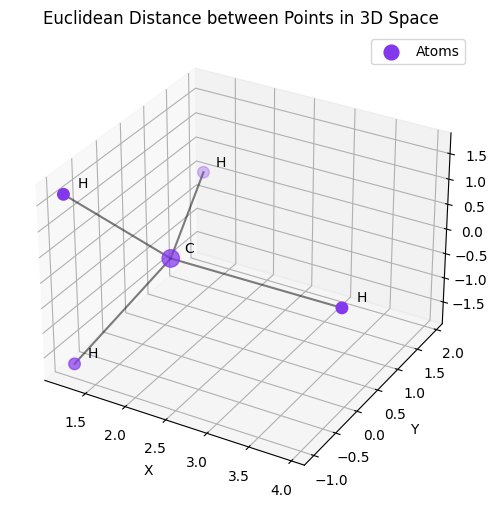

In [889]:
labels = ['C', 'H', 'H', 'H', 'H']
np_three_d_point_arr_non_empty_atoms = np.array(three_d_point_arr_non_empty_atoms)
print(np_three_d_point_arr_non_empty_atoms.shape)

# Calculate 3D Euclidean distance between points
distances = np.zeros((np_three_d_point_arr_non_empty_atoms.shape[0], np_three_d_point_arr_non_empty_atoms.shape[0]))
for i in range(np_three_d_point_arr_non_empty_atoms.shape[0]):
    for j in range(np_three_d_point_arr_non_empty_atoms.shape[0]):
        distances[i, j] = np.linalg.norm(np_three_d_point_arr_non_empty_atoms[i] - np_three_d_point_arr_non_empty_atoms[j])

# Plotting
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

explanation = explanations[0]

# Scatter plot of points
ax.scatter(np_three_d_point_arr_non_empty_atoms[:, 0],
           np_three_d_point_arr_non_empty_atoms[:, 1],
           np_three_d_point_arr_non_empty_atoms[:, 2],
           color='#8338ec',
           label='Atoms',
           s = abs(explanation[explanation != 0]))

# Plotting lines for Euclidean distances
for i in range(np_three_d_point_arr_non_empty_atoms.shape[0]):
    for j in range(i+1, np_three_d_point_arr_non_empty_atoms.shape[0]):
        if(distances[i][j] <= threshold):
            x = [np_three_d_point_arr_non_empty_atoms[i, 0], np_three_d_point_arr_non_empty_atoms[j, 0]]
            y = [np_three_d_point_arr_non_empty_atoms[i, 1], np_three_d_point_arr_non_empty_atoms[j, 1]]
            z = [np_three_d_point_arr_non_empty_atoms[i, 2], np_three_d_point_arr_non_empty_atoms[j, 2]]
            ax.plot(x, y, z, color='#000000', alpha=0.5)
    ax.text(np_three_d_point_arr_non_empty_atoms[i][0] + 0.15, np_three_d_point_arr_non_empty_atoms[i][1] + 0.15, np_three_d_point_arr_non_empty_atoms[i][2] + 0.15, f'{labels[i]}', ha='center', va='center')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Euclidean Distance between Points in 3D Space')
plt.legend()
plt.show()

# size of atom denotes its contribution to the prediction

## 3.2 Models with Pairs of Atoms

In [890]:
# Given atomic number array , find out the unique pairs
def find_pairs(atomic_number_list):
    atom_pairs = []
    for i in range(len(atomic_number_list)):
        for j in range(i, len(atomic_number_list), 1):
            temp = []
            if(atomic_number_list[i] != 0.0 and atomic_number_list[j] != 0.0):
                temp.append(atomic_number_list[i])
                temp.append(atomic_number_list[j])
                atom_pairs.append(temp)
        np_atom_pairs = np.array(atom_pairs)
    # print(np_atom_pairs.shape) #  The number of pairs differ from molecle to molecule
    return atom_pairs

In [891]:
#Find out pairwise distance of all pairs of all molecule. Each molecule has different distinct pairs
distance_between_pairwise_atoms_for_all_molecules = []
for i in range(len(R)): # picking molecule
    distance_between_unique_pairwise_atoms_of_a_molecule = []
    for j in range(len(R[i])): # picking one atom
        for k in range(j, len(R[i]), 1): # picking another atom
            """
            Sometimes an atom can have just one non-zero coordinate or two non-zero coordinate
            It is not mandatory for the atom to have all three cordinates as non-zero
            """ 
            if (R[i][j][0] != 0.0 or R[i][j][1] != 0.0 or R[i][j][2] != 0.0) and (R[i][k][0] != 0.0 or R[i][k][1] != 0.0 or R[i][k][2] != 0.0):
                euclidean_distance_between_a_pair_of_points = np.linalg.norm(R[i][j] - R[i][k])
                distance_between_unique_pairwise_atoms_of_a_molecule.append(euclidean_distance_between_a_pair_of_points)
    distance_between_pairwise_atoms_for_all_molecules.append(distance_between_unique_pairwise_atoms_of_a_molecule)

np_distance_between_pairwise_atoms_for_all_molecules = np.array(distance_between_pairwise_atoms_for_all_molecules, dtype='object')
print(np_distance_between_pairwise_atoms_for_all_molecules.shape)


# Printing min and max helps in choosing the right interval range for distance based atomic pair one hot encoding 
print(np.min(distance_between_pairwise_atoms_for_all_molecules))
print(np.max(distance_between_pairwise_atoms_for_all_molecules))


(7165,)
[0.0, 2.063549, 2.0635345, 2.0635827, 2.0651567, 0.0, 3.3701808, 3.3701982, 3.3706563, 0.0, 3.3701925, 3.3706532, 0.0, 3.3706717, 0.0]
[0.0, 3.3644285, 4.943236, 4.955782, 5.2981253, 5.931887, 6.669132, 2.0604253, 2.0609035, 2.0629683, 7.111933, 5.610726, 6.8602858, 0.0, 2.7402794, 2.7407596, 3.3438766, 5.0107164, 6.7405605, 4.490741, 4.4762564, 4.4534097, 4.454214, 4.458637, 5.625007, 0.0, 4.7590923, 4.917754, 7.3125577, 8.933731, 6.672544, 5.304287, 5.4679008, 5.443953, 5.2928815, 8.116186, 0.0, 4.923379, 5.59777, 7.6279864, 5.3477573, 6.673732, 5.4658647, 5.46083, 6.64808, 5.1465592, 0.0, 2.8114915, 4.506631, 5.64305, 5.634431, 7.09604, 2.06421, 2.0629592, 4.1832004, 0.0, 2.3212185, 5.233647, 6.576083, 7.797189, 4.008241, 4.0453587, 2.0862465, 0.0, 5.6070566, 6.862665, 8.628938, 5.8924437, 4.8099504, 3.8365583, 0.0, 3.3966098, 3.3696032, 7.546336, 6.1801853, 5.9610333, 0.0, 3.3803303, 7.5253077, 5.164552, 7.976181, 0.0, 8.721743, 7.502817, 8.424968, 0.0, 3.3779318, 4.761704,

/Users/mac/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [892]:
# Atomic Pair based One hot encoding based on atom's atomic number
one_hot_encoded_atom_pairs_for_all_molecules=[]
for i in range(len(Z)):
    pairs = find_pairs(Z[i]) # Getting atom pairs for each molecule
    one_hot_encoded_atom_pairs_of_a_molecule=[]
    for j in range(len(pairs)):
        if(pairs[j][0] == 1.0 and pairs[j][1] == 1.0 ) :
            one_hot_encoding_atom_pair_array = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif(pairs[j][0] == 1.0 and pairs[j][1] == 6.0 ) :
            one_hot_encoding_atom_pair_array = [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif(pairs[j][0] == 1.0 and pairs[j][1] == 7.0 ) :
            one_hot_encoding_atom_pair_array = [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]
        elif(pairs[j][0] == 1.0 and pairs[j][1] == 8.0 ) :
            one_hot_encoding_atom_pair_array = [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]
        elif(pairs[j][0] == 1.0 and pairs[j][1] == 16.0 ) :
            one_hot_encoding_atom_pair_array = [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]
        elif(pairs[j][0] == 6.0 and pairs[j][0] == 6.0 ) :
            one_hot_encoding_atom_pair_array = [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]
        elif(pairs[j][0] == 6.0 and pairs[j][1] == 7.0 ) :
            one_hot_encoding_atom_pair_array = [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]
        elif(pairs[j][0] == 6.0 and pairs[j][1] == 8.0 ) :
            one_hot_encoding_atom_pair_array = [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]
        elif(pairs[j][0] == 6.0 and pairs[j][1] == 16.0 ) :
            one_hot_encoding_atom_pair_array = [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]
        elif(pairs[j][0] == 7.0 and pairs[j][1] == 7.0 ) :
            one_hot_encoding_atom_pair_array = [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]
        elif(pairs[j][0] == 7.0 and pairs[j][1] == 8.0 ) :
            one_hot_encoding_atom_pair_array = [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]
        elif(pairs[j][0] == 7.0 and pairs[j][1] == 16.0 ) :
            one_hot_encoding_atom_pair_array = [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]
        elif(pairs[j][0] == 8.0 and pairs[j][1] == 8.0 ) :
            one_hot_encoding_atom_pair_array = [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]
        elif(pairs[j][0] == 8.0 and pairs[j][1] == 16.0 ) :
            one_hot_encoding_atom_pair_array = [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]
        elif(pairs[j][0] == 16.0 and pairs[j][1] == 16.0 ) :
            one_hot_encoding_atom_pair_array = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
        else:
            one_hot_encoding_atom_pair_array = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        one_hot_encoded_atom_pairs_of_a_molecule.append(one_hot_encoding_atom_pair_array)
    one_hot_encoded_atom_pairs_for_all_molecules.append(one_hot_encoded_atom_pairs_of_a_molecule)

one_hot_encoded_atom_pairs_for_all_molecules = np.array(one_hot_encoded_atom_pairs_for_all_molecules, dtype='object')
print(one_hot_encoded_atom_pairs_for_all_molecules.shape)


(7165,)


In [893]:
# Atom distance interval between aromic pairs based one hot encoding 

intervals = [0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6, 4.2, 4.8, 5.4, 6.0, 6.6, 7.2, 7.8, 8.4, 9.0]

# Iterate over np_distance_between_pairwise_atoms_for_all_molecules and perform one hot encoding
one_hot_encoded_distance_atom_pairs_for_all_molecules=[]
for i in range(len(np_distance_between_pairwise_atoms_for_all_molecules)):
    one_hot_encoded_distance_atom_pairs_of_a_molecule=[]
    m = np_distance_between_pairwise_atoms_for_all_molecules[i]
    for j in range(len(m)):
        if(m[j] >= intervals[0] and m[j] < intervals[1] ) :
            one_hot_distance_encoding_atom_pair_array = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif(m[j] >= intervals[1] and m[j] < intervals[2] ) :
            one_hot_distance_encoding_atom_pair_array = [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif(m[j] >= intervals[2] and m[j] < intervals[3] ) :
            one_hot_distance_encoding_atom_pair_array = [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]
        elif(m[j] >= intervals[3] and m[j] < intervals[4] ) :
            one_hot_distance_encoding_atom_pair_array = [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]
        elif(m[j] >= intervals[4] and m[j] < intervals[5] ) :
            one_hot_distance_encoding_atom_pair_array = [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]
        elif(m[j] >= intervals[5] and m[j] < intervals[6] ) :
            one_hot_distance_encoding_atom_pair_array = [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]
        elif(m[j] >= intervals[6] and m[j] < intervals[7] ) :
            one_hot_distance_encoding_atom_pair_array = [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]
        elif(m[j] >= intervals[7] and m[j] < intervals[8] ) :
            one_hot_distance_encoding_atom_pair_array = [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]
        elif(m[j] >= intervals[8] and m[j] < intervals[9] ) :
            one_hot_distance_encoding_atom_pair_array = [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]
        elif(m[j] >= intervals[9] and m[j] < intervals[10] ) :
            one_hot_distance_encoding_atom_pair_array = [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]
        elif(m[j] >= intervals[10] and m[j] < intervals[11] ) :
            one_hot_distance_encoding_atom_pair_array = [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]
        elif(m[j] >= intervals[11] and m[j] < intervals[12] ) :
            one_hot_distance_encoding_atom_pair_array = [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]
        elif(m[j] >= intervals[12] and m[j] < intervals[13] ) :
            one_hot_distance_encoding_atom_pair_array = [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]
        elif(m[j] >= intervals[13] and m[j] < intervals[14] ) :
            one_hot_distance_encoding_atom_pair_array = [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]
        elif(m[j] >= intervals[14] and m[j] < intervals[15] ) :
            one_hot_distance_encoding_atom_pair_array = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
        else:
            one_hot_distance_encoding_atom_pair_array = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        one_hot_encoded_distance_atom_pairs_of_a_molecule.append(one_hot_distance_encoding_atom_pair_array)
    one_hot_encoded_distance_atom_pairs_for_all_molecules.append(one_hot_encoded_distance_atom_pairs_of_a_molecule)

np_one_hot_encoded_distance_atom_pairs_for_all_molecules = np.array(one_hot_encoded_distance_atom_pairs_for_all_molecules, dtype='object')
print(np_one_hot_encoded_distance_atom_pairs_for_all_molecules.shape)


(7165,)


In [894]:
def get_final_feature_map(np_one_hot_encoded_distance_atom_pairs_for_all_molecules, np_one_hot_encoded_atom_pairs_for_all_molecules):
    fm_explained = []
    fm = []
    for i in range(Z.shape[0]): # For each molecule 
        temp = []
        # For each pair of atoms in a molecule
        for j in range(len(np_one_hot_encoded_distance_atom_pairs_for_all_molecules[i])):
            A = np.array(np_one_hot_encoded_distance_atom_pairs_for_all_molecules[i][j])
            B = np.array(np_one_hot_encoded_atom_pairs_for_all_molecules[i][j])
            t = np.zeros((len(A), len(B)))
            # for feature map A
            for l in range(len(A)):
                # For feature map B
                for m in range(len(B)):
                    # Multiplying fmA and fmB and getting results
                    t[l][m] = A[l] * B[m]
            t = t.flatten() # getting 225 X 1 
            temp.append(t) # temp corresponds to one pair of atoms
        # Captures one hot encoding info for all atomic pairs in a molecule as it is - 7165 X(num pairs) X 225
        np_temp = np.array(temp) # number_of_pairs X 225
        fm_explained.append(np_temp)
        # Captures one hot encoding at the molecule level 7165 X 225(by summing up one hot encoding across column)
        fm.append(np.sum(temp, axis=0))
    return np.array(fm), np.array(fm_explained, dtype='object')

In [895]:
# This takes around 2 minutes time to execute on 6 core , 16 GB RAM local machine 
import time
start = time.process_time()   
fm, fm_explained = get_final_feature_map(np_one_hot_encoded_distance_atom_pairs_for_all_molecules, one_hot_encoded_atom_pairs_for_all_molecules)
end = time.process_time()
print(end - start)
print(fm.shape)
print(fm_explained.shape)

104.61262100000022
(7165, 225)
(7165,)


In [896]:
# Centering the fm
fm = fm - np.mean(fm, axis = 0, keepdims = True)

In [897]:
# Getting the weight W for base_lambd_2
base_lambd_2 = 1e-30
W = get_weight(fm, T, base_lambd_2) # T and fm are already centered
print(W.shape)

(225, 1)


In [898]:
# Prediction for atomisation energy for dual pair based one hot encoding logic 
pred = np.dot(fm, W)
print(pred.shape)

(7165, 1)


In [899]:
# Error with one chosen lambda
base_err_2 = mean_absolute_error(T, pred)
print(base_err_2)

9.78075157368635


In [900]:
# Error reduction and choosing best lambda
lambdas_2 = [1.0, 0.5,0.1, 0.01, 0.001, 0.0001, 
             0.00001, 0.000001, 0.0000001, 0.00000001, 
             0.000000001, 0.0000000001, 0.0000000001, 0.0000000001, 1e-30, 1e-50, 1e-80]
best_lambd_2 = base_lambd_2
print("best_lambd_2 is : ", best_lambd_2)
least_error_2 = base_err_2
print("least_error_2 is : ", least_error_2)
for lambd in lambdas_2:
    W = get_weight(fm,T,lambd) #  T and fm are centered 
    pred = np.dot(fm, W)
    err = mean_absolute_error(T, pred)
    print("Error in FM case is : ", err)
    if(err < least_error_2):
        best_lambd_2 = lambd
        least_error_2 = err

print("Least Mean Absolute Error : ", least_error_2)
print("Best lambda : ", best_lambd_2)

best_lambd_2 is :  1e-30
least_error_2 is :  9.78075157368635
Error in FM case is :  40.87272824245175
Error in FM case is :  37.28707919281133
Error in FM case is :  25.844110777841543
Error in FM case is :  12.059503853972718
Error in FM case is :  9.896722911616065
Error in FM case is :  9.793047241559202
Error in FM case is :  9.782269347280954
Error in FM case is :  9.780904563200757
Error in FM case is :  9.780766922472466
Error in FM case is :  9.780753064694355
Error in FM case is :  9.780751679181412
Error in FM case is :  9.780751583675675
Error in FM case is :  9.780751583675675
Error in FM case is :  9.780751583675675
Error in FM case is :  9.78075157368635
Error in FM case is :  9.78075157368635
Error in FM case is :  9.78075157368635
Least Mean Absolute Error :  9.78075157368635
Best lambda :  1e-30


In [901]:
fm_ex = np.dot(fm_explained[0], W)
calculated_atomisation_energy = np.sum(fm_ex, axis=0)
print(np.sum(fm_ex, axis=0))
print(T_Copy[0][0])

error_in_pairwise_atoms_case = abs(abs(T_Copy[0][0]) - abs(calculated_atomisation_energy))
print("error_in_pairwise_atoms_case is :", error_in_pairwise_atoms_case)

[-419.63248794]
-417.96
error_in_pairwise_atoms_case is : [1.67249648]


(5, 3)


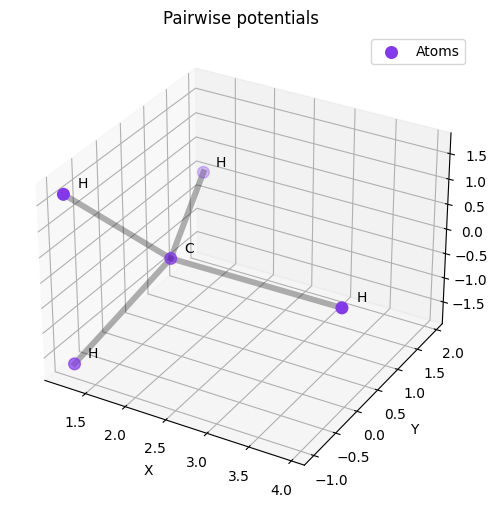

In [902]:
labels = ['C', 'H', 'H', 'H', 'H']

fm_ex = np.dot(fm_explained[0], W)

np_three_d_point_arr_non_empty_atoms = np.array(three_d_point_arr_non_empty_atoms)
print(np_three_d_point_arr_non_empty_atoms.shape)

# Calculate 3D Euclidean distance between points
distances = np.zeros((np_three_d_point_arr_non_empty_atoms.shape[0], np_three_d_point_arr_non_empty_atoms.shape[0]))
for i in range(np_three_d_point_arr_non_empty_atoms.shape[0]):
    for j in range(np_three_d_point_arr_non_empty_atoms.shape[0]):
        distances[i, j] = np.linalg.norm(np_three_d_point_arr_non_empty_atoms[i] - np_three_d_point_arr_non_empty_atoms[j])

# Plotting
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of points
ax.scatter(np_three_d_point_arr_non_empty_atoms[:, 0],
           np_three_d_point_arr_non_empty_atoms[:, 1],
           np_three_d_point_arr_non_empty_atoms[:, 2],
           color='#8338ec',
           label='Atoms',
           s=70)

# Plotting lines for Euclidean distances
# Making thicker bonds for large values - R[0]
for i in range(np_three_d_point_arr_non_empty_atoms.shape[0]):
    for j in range(i, np_three_d_point_arr_non_empty_atoms.shape[0]):
        if(distances[i][j] <= threshold):
            x = [np_three_d_point_arr_non_empty_atoms[i, 0], np_three_d_point_arr_non_empty_atoms[j, 0]]
            y = [np_three_d_point_arr_non_empty_atoms[i, 1], np_three_d_point_arr_non_empty_atoms[j, 1]]
            z = [np_three_d_point_arr_non_empty_atoms[i, 2], np_three_d_point_arr_non_empty_atoms[j, 2]]
            ax.plot(x, y, z, color='#000000', alpha=0.3, linewidth = abs(fm_ex[i]/35) )
    ax.text(np_three_d_point_arr_non_empty_atoms[i][0] + 0.15, np_three_d_point_arr_non_empty_atoms[i][1] + 0.15, np_three_d_point_arr_non_empty_atoms[i][2] + 0.15, f'{labels[i]}', ha='center', va='center')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Pairwise potentials')
plt.legend()
plt.show()